In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [4]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


In [9]:
recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=1, max_unidades=5,
                                                  min_kcal=250, max_kcal= 1500,
                                                  numero_recetas=1
                                                  )

# recomendador128.generar_dataset_entrenamiento_precios(df_precios_profeco='lista_precios_profeco_2022.csv', 
#                                                   numero_recetas=1
#                                                   )                                  

Generando 1  recetas aleatorias...



100%|██████████| 1/1 [00:00<00:00, 501.05it/s]


array([['4 cucharadas de pollo  frito  cocido  solo carne  pollos de engorde o fryers, 3 onzas de aguacates  florida  crudo, 1 tazas de jugo de limón de concentrado  enlatado o embotellado, 1 onzas de carne de res  cruda  seleccionada  degada y grasa separable  chuck para estofado, 2 piezas de pavo  crudo  carne y piel  muslo  piezas minoristas, 1 cucharaditas de palomitas de maíz  sin grasa  jarabe de azúcar/caramelo, 4 gramos de spreading de aceite vegetal  calorías reducidas',
        '477.99', '6.73', '47.2', '30.16']], dtype='<U473')

* Entrenar información nutricional

In [ ]:
recomendador128.NUM_RECETAS = 1000
recomendador128.EMB_SIZE = 128
ITER = 2
INITIAL_EPOCH = 0
EPOCHS = 50

Rangos_kcal = [
                (250, 1500),
                (450, 2000)           
              ]

Histories = []
for iteracion in range(ITER):
  MINU = 1 
  MAXU = 11  

  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                  #df_training='recipes_con_info_nutricional.csv',
                                  df_test='recetas_test.csv', 
                                  df_val='recetas_val.csv',
                                  learning_rate=1e-4,
                                  version=version, 
                                  initial_epoch = INITIAL_EPOCH,                             
                                  epochs=INITIAL_EPOCH + EPOCHS, 
                                  kernels=128,                                             
                                  min_ingredientes=5, max_ingredientes=11,
                                  min_unidades=MINU, max_unidades=MAXU,  
                                  min_kcal=MINK, max_kcal= MAXK,                             
                                  save=True, verbose=True)
    INITIAL_EPOCH = history.epoch[-1]

    Histories.append(history)


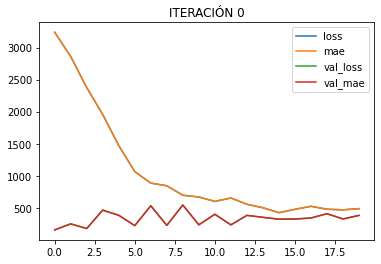

LOSS: 487.992919921875  -- MAE: 487.992919921875  -- VAL_LOSS: 382.4871826171875  -- VAL_MAE: 382.4871826171875
----------------------------------------------------------


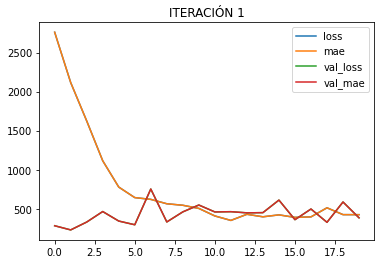

LOSS: 423.4921875  -- MAE: 423.4921875  -- VAL_LOSS: 382.8998107910156  -- VAL_MAE: 382.8998107910156
----------------------------------------------------------


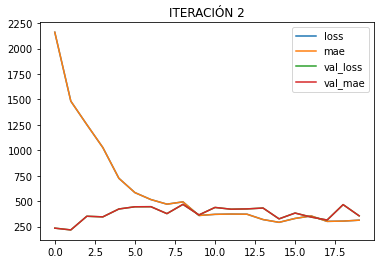

LOSS: 313.53253173828125  -- MAE: 313.53253173828125  -- VAL_LOSS: 356.08251953125  -- VAL_MAE: 356.08251953125
----------------------------------------------------------


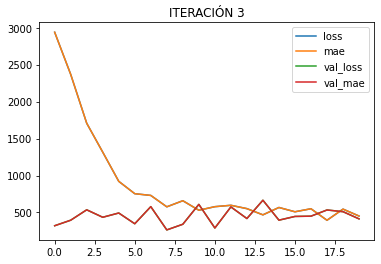

LOSS: 451.75457763671875  -- MAE: 451.75457763671875  -- VAL_LOSS: 413.34716796875  -- VAL_MAE: 413.34716796875
----------------------------------------------------------


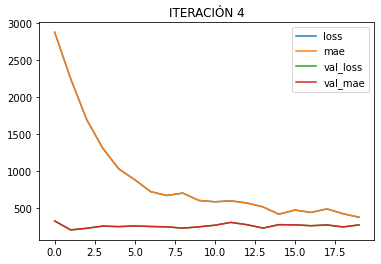

LOSS: 379.353759765625  -- MAE: 379.353759765625  -- VAL_LOSS: 275.9854736328125  -- VAL_MAE: 275.9854736328125
----------------------------------------------------------


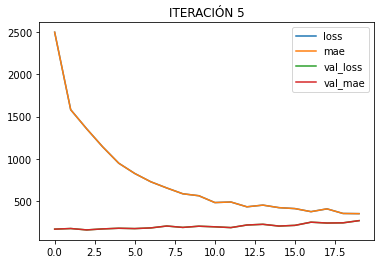

LOSS: 352.16168212890625  -- MAE: 352.16168212890625  -- VAL_LOSS: 269.5182189941406  -- VAL_MAE: 269.5182189941406
----------------------------------------------------------


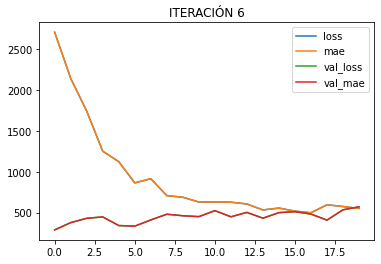

LOSS: 551.0586547851562  -- MAE: 551.0586547851562  -- VAL_LOSS: 571.1595458984375  -- VAL_MAE: 571.1595458984375
----------------------------------------------------------


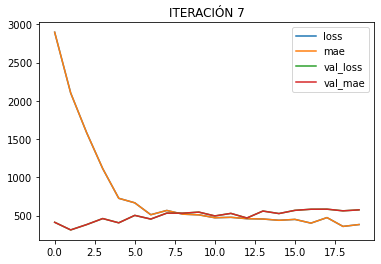

LOSS: 382.1382751464844  -- MAE: 382.1382751464844  -- VAL_LOSS: 574.2182006835938  -- VAL_MAE: 574.2182006835938
----------------------------------------------------------


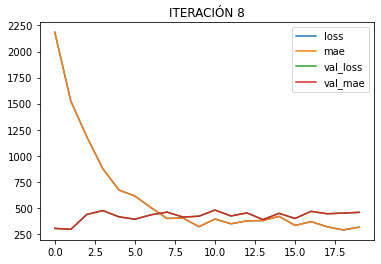

LOSS: 313.9268493652344  -- MAE: 313.9268493652344  -- VAL_LOSS: 456.5428466796875  -- VAL_MAE: 456.5428466796875
----------------------------------------------------------


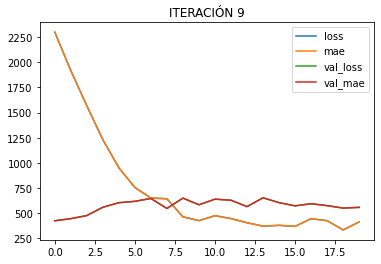

LOSS: 410.5537414550781  -- MAE: 410.5537414550781  -- VAL_LOSS: 555.5153198242188  -- VAL_MAE: 555.5153198242188
----------------------------------------------------------


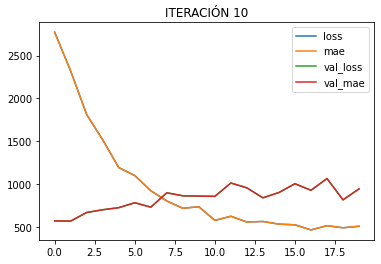

LOSS: 509.4301452636719  -- MAE: 509.4301452636719  -- VAL_LOSS: 945.4789428710938  -- VAL_MAE: 945.4789428710938
----------------------------------------------------------


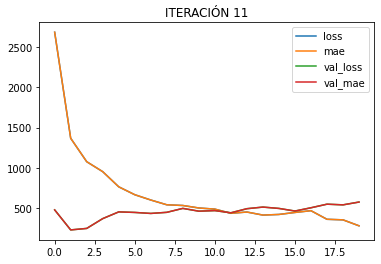

LOSS: 278.8351135253906  -- MAE: 278.8351135253906  -- VAL_LOSS: 574.349853515625  -- VAL_MAE: 574.349853515625
----------------------------------------------------------


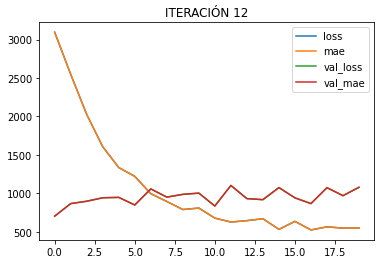

LOSS: 549.5899047851562  -- MAE: 549.5899047851562  -- VAL_LOSS: 1078.7447509765625  -- VAL_MAE: 1078.7447509765625
----------------------------------------------------------


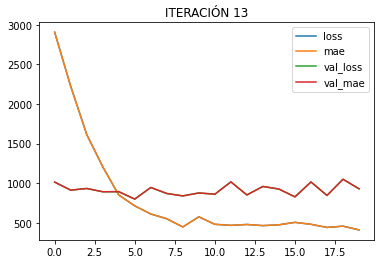

LOSS: 411.22308349609375  -- MAE: 411.22308349609375  -- VAL_LOSS: 929.8006591796875  -- VAL_MAE: 929.8006591796875
----------------------------------------------------------


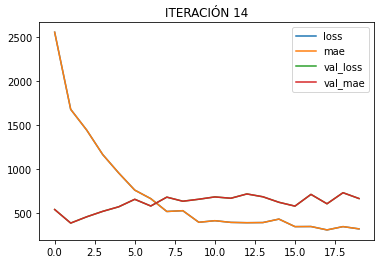

LOSS: 316.0512390136719  -- MAE: 316.0512390136719  -- VAL_LOSS: 661.1712036132812  -- VAL_MAE: 661.1712036132812
----------------------------------------------------------


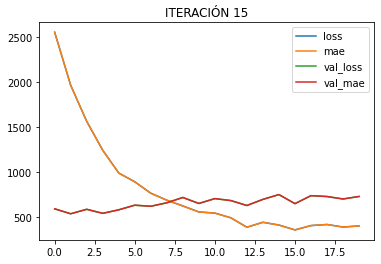

LOSS: 404.5737609863281  -- MAE: 404.5737609863281  -- VAL_LOSS: 731.4818115234375  -- VAL_MAE: 731.4818115234375
----------------------------------------------------------


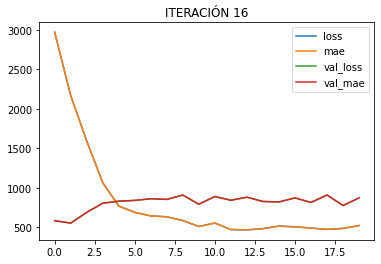

LOSS: 521.7587280273438  -- MAE: 521.7587280273438  -- VAL_LOSS: 871.3925170898438  -- VAL_MAE: 871.3925170898438
----------------------------------------------------------


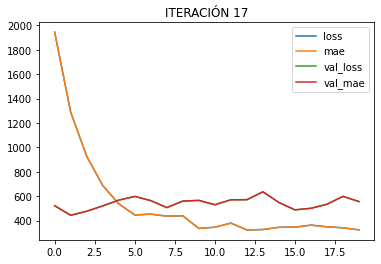

LOSS: 323.7760009765625  -- MAE: 323.7760009765625  -- VAL_LOSS: 555.6675415039062  -- VAL_MAE: 555.6675415039062
----------------------------------------------------------


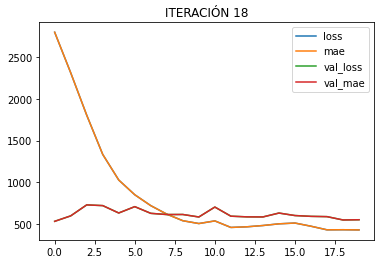

LOSS: 429.9709777832031  -- MAE: 429.9709777832031  -- VAL_LOSS: 551.8583984375  -- VAL_MAE: 551.8583984375
----------------------------------------------------------


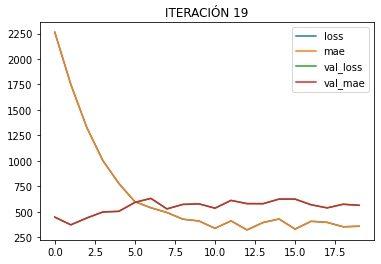

LOSS: 357.5840759277344  -- MAE: 357.5840759277344  -- VAL_LOSS: 562.87841796875  -- VAL_MAE: 562.87841796875
----------------------------------------------------------


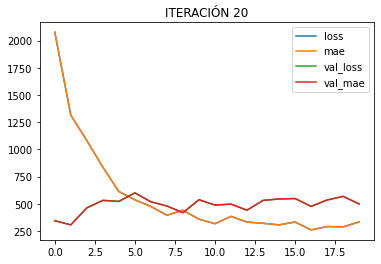

LOSS: 333.9403381347656  -- MAE: 333.9403381347656  -- VAL_LOSS: 498.5685119628906  -- VAL_MAE: 498.5685119628906
----------------------------------------------------------


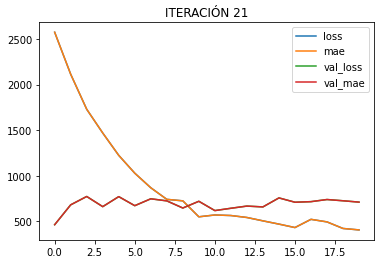

LOSS: 404.94195556640625  -- MAE: 404.94195556640625  -- VAL_LOSS: 710.0248413085938  -- VAL_MAE: 710.0248413085938
----------------------------------------------------------


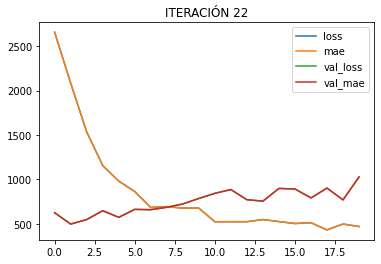

LOSS: 469.57110595703125  -- MAE: 469.57110595703125  -- VAL_LOSS: 1027.3345947265625  -- VAL_MAE: 1027.3345947265625
----------------------------------------------------------


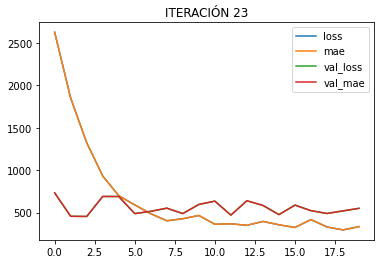

LOSS: 334.9266357421875  -- MAE: 334.9266357421875  -- VAL_LOSS: 550.7179565429688  -- VAL_MAE: 550.7179565429688
----------------------------------------------------------


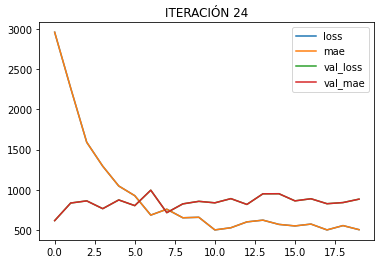

LOSS: 502.48101806640625  -- MAE: 502.48101806640625  -- VAL_LOSS: 882.603515625  -- VAL_MAE: 882.603515625
----------------------------------------------------------


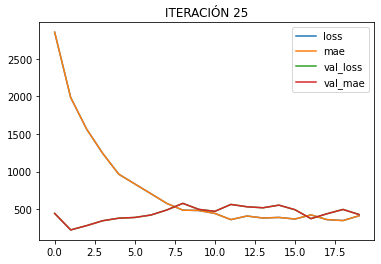

LOSS: 410.96148681640625  -- MAE: 410.96148681640625  -- VAL_LOSS: 428.2132873535156  -- VAL_MAE: 428.2132873535156
----------------------------------------------------------


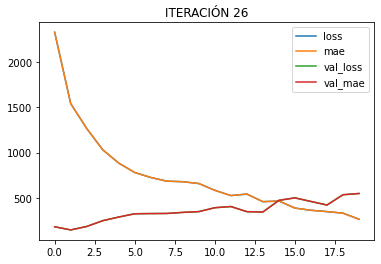

LOSS: 265.369873046875  -- MAE: 265.369873046875  -- VAL_LOSS: 548.9364013671875  -- VAL_MAE: 548.9364013671875
----------------------------------------------------------


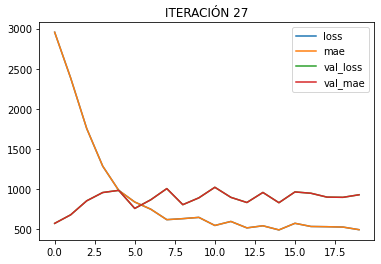

LOSS: 496.63226318359375  -- MAE: 496.63226318359375  -- VAL_LOSS: 931.2688598632812  -- VAL_MAE: 931.2688598632812
----------------------------------------------------------


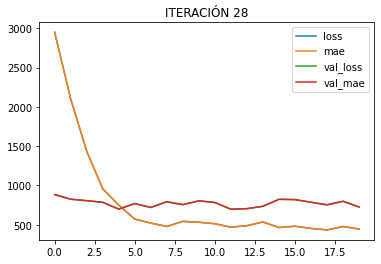

LOSS: 445.271240234375  -- MAE: 445.271240234375  -- VAL_LOSS: 726.227783203125  -- VAL_MAE: 726.227783203125
----------------------------------------------------------


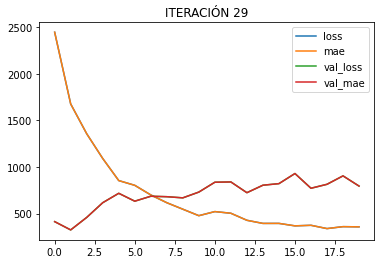

LOSS: 357.1131286621094  -- MAE: 357.1131286621094  -- VAL_LOSS: 794.7628784179688  -- VAL_MAE: 794.7628784179688
----------------------------------------------------------


In [7]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Entrenar precios


ITERACIÓN: 1
Entrenando desde epoch 50
------------------------------------------

Generando 100  recetas aleatorias...



100%|██████████| 100/100 [00:00<00:00, 519.52it/s]


Calculando vector de características de 100 recetas...


100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 POOLING_1 (MaxPooling1D)    (None, 123, 512)          0         
                                                                 
 CONV_2 (Conv1D)             (None, 121, 256)          393472    
                                                  

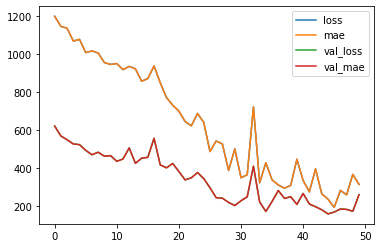

1/1 [==============================] - 0s 230ms/step - loss: 660.3191 - mae: 660.3191
[660.319091796875, 660.319091796875]
1/1 [==============================] - 0s 184ms/step
receta 0 precio_prom_por_gramo_true: 284.2 precio_prom_por_gramo_pred: 148.11043  precisión: 52.1 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 309.5 precio_prom_por_gramo_pred: 307.6047  precisión: 99.4 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 9780.0 precio_prom_por_gramo_pred: 8269.006  precisión: 84.6 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 4.67 precio_prom_por_gramo_pred: 290.65585  precisión: 1.6 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 275.0 precio_prom_por_gramo_pred: 237.93599  precisión: 86.5 %
-----------------------

100%|██████████| 100/100 [00:00<00:00, 604.13it/s]


Calculando vector de características de 100 recetas...


100%|██████████| 100/100 [04:22<00:00,  2.63s/it]


Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 POOLING_1 (MaxPooling1D)    (None, 123, 512)          0         
                                                                 
 CONV_2 (Conv1D)             (None, 121, 256)          393472    
                                                  

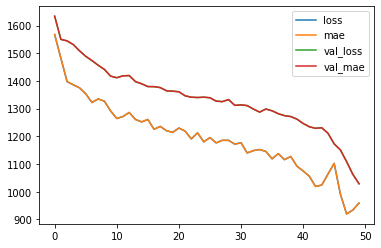

1/1 [==============================] - 0s 238ms/step - loss: 112.0643 - mae: 112.0643
[112.06428527832031, 112.06428527832031]
1/1 [==============================] - 0s 184ms/step
receta 0 precio_prom_por_gramo_true: 53.78 precio_prom_por_gramo_pred: 134.9993  precisión: 39.8 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 308.5 precio_prom_por_gramo_pred: 241.38097  precisión: 78.2 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 731.5 precio_prom_por_gramo_pred: 911.13947  precisión: 80.3 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 342.0 precio_prom_por_gramo_pred: 409.44962  precisión: 83.5 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 217.0 precio_prom_por_gramo_pred: 255.90727  precisión: 84.8 %
-----------------

In [7]:
recomendador128.NUM_RECETAS = 100
recomendador128.EMB_SIZE = 128
ITER = 2
INITIAL_EPOCH = 50
EPOCHS = 50


Histories_precios = []
for iteracion in range(ITER):
    print('\nITERACIÓN:', iteracion+1)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128_precios, history_precios = recomendador128.EntrenarModeloPrecios(
                                    df_precios='lista_precios_profeco_2022.csv',                                   
                                    learning_rate=1e-3,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    kernels=128,                                                                         
                                    save=True, verbose=True)
    INITIAL_EPOCH = history_precios.epoch[-1]

    Histories_precios.append(history_precios)

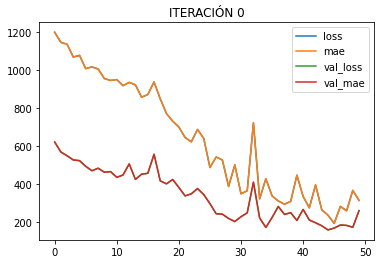

LOSS: 312.3093566894531  -- MAE: 312.3093566894531  -- VAL_LOSS: 258.28533935546875  -- VAL_MAE: 258.28533935546875
----------------------------------------------------------


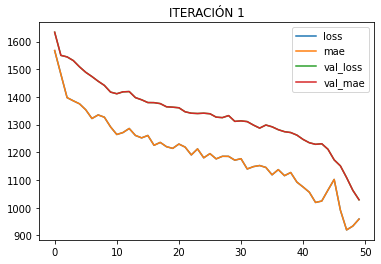

LOSS: 959.3097534179688  -- MAE: 959.3097534179688  -- VAL_LOSS: 1028.807861328125  -- VAL_MAE: 1028.807861328125
----------------------------------------------------------


In [8]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')